## Theory

The task to optimize for the risk and return, hence for the allocation for $w$\
$$\sigma_\Pi = \sqrt{w^*`\Sigma w^*}$$ 
$$μ_Π = w^*` μ $$
$$ \underset{w}{\operatorname{argmin}} \frac{1}{2} w' \Sigma w $$
for target returns $m$\
$$m =  \ r + (\mu - r I)'w$$
\
with the constraint that the net of allocations are invested (borrowed) in the risk-free $r$ assets,
boils dow to formulating the Lagrangian function, and its partial derivatives,\
$ L(w,\gamma) = \frac{1}{2} w' \Sigma w  + \gamma \ \big( (m - r) - (\mu - rI)' w \big) + \lambda (1 - w'I) $\
\
and solving for\
$\frac{∂L(w,γ)}{∂w} = 0$\
\
ie.

$ \frac{\partial L}{\partial w} = \Sigma w- \gamma (\mu -rI) - \lambda I= 0 $

$ \frac{\partial L}{\partial \gamma} = (m - r) - (\mu - rI)' w = 0 $

$ \frac{\partial^2 L}{\partial \lambda} = 1 - w'I = 0\ $

$ \frac{\partial^2 L}{\partial w^2} = \Sigma \ and \ \Sigma > 0 \ \implies L\ has\ minimum $

$\dots$

$ w = \Sigma^{-1} \Big( \gamma (\mu - rI) + \lambda I \Big) $

$ w = \frac{(m - r)}{(\mu -rI)'} $

$ w'I = 1 \ (budget~equation) $

$ \dots $

$
\cases{
C \gamma + B \lambda = m - r \cr
B \gamma + A \lambda = 1 
} 
$

$ where $

$ A = I' \Sigma^{-1} I $

$ B = I' \Sigma^{-1} (\mu - rI) = (\mu - rI)' \Sigma^{-1} I $

$ C = (\mu - rI)' \Sigma^{-1} (\mu - rI) $

$ \dots $

$ \gamma = \frac {A (m - r) - B}{A C - B^2} $

$ \lambda = \frac {C - B (m - r)}{A C - B^2} $


$ w(m) = \Sigma^{-1} \Big( \gamma(m) \ (\mu - r I) + \lambda(m) \ I \Big) $


## Portfolio and Correlations

In [1]:
portfolio_str = """
Assets μ σ
A 0.05 0.10
B 0.075 0.10
C 0.10 0.30
D 0.125 0.70
"""

from io import StringIO
portfolio_df = pd.read_csv(StringIO(portfolio_str),sep=' ',index_col=['Assets'])
portfolio_df

,μ,σ
Assets,,
A,0.050,0.1
B,0.075,0.1
C,0.100,0.3
D,0.125,0.7


In [2]:
Corr = np.matrix([
[1.0, 0.2, 0.3, 0.2],
[0.2, 1.0, 0.5, 0.4],
[0.3, 0.5, 1.0, 0.6],
[0.2, 0.4, 0.6, 1.0]
])
Corr

matrix([[1. , 0.2, 0.3, 0.2],
        [0.2, 1. , 0.5, 0.4],
        [0.3, 0.5, 1. , 0.6],
        [0.2, 0.4, 0.6, 1. ]])

## Algebraic Computaions

In [3]:
# computation parameters
r = 0.01 # risk-free rate = 1%
μ = np.matrix( portfolio_df['μ'] ).T 
I = np.matrix( np.ones(len(μ)) ).T
rI = np.matrix( r*np.ones(len(μ)) ).T
diag_σ = np.diag( portfolio_df['σ'] )
Σ = diag_σ * Corr * diag_σ
A = I.T * Σ**-1 * I
B = I.T * Σ**-1 * (μ - rI)
C = (μ - rI).T * Σ**-1 * (μ - rI)

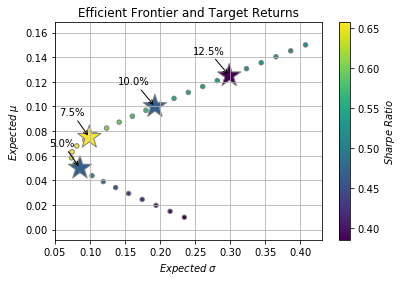

In [4]:
# plot 
def plot_efficient_frontier(m_ary, marker='o',annotations=False):
    μ_ary = []
    σ_ary = []
    for m in m_ary:
        γ = (A*(m-r) - B) / (A*C - B**2)
        λ = (C - B*(m-r)) / (A*C - B**2)
        γ = γ.item()
        λ = λ.item()    
        w = Σ**-1 * (γ*(μ - rI) + λ*I)
        σ_Π = np.sqrt( w.T * Σ * w )
        μ_Π = w.T * μ
        σ_ary.append(σ_Π)
        μ_ary.append(μ_Π)
    # do type conversin for plotting
    μ_ary = np.array([ _.item() for _ in μ_ary])
    σ_ary = np.array([ _.item() for _ in σ_ary])
    # plot the efficient frontier
    marker_size = 600 if marker == '*' else 20
    plt.scatter(σ_ary, μ_ary, c=(μ_ary -r)/σ_ary, marker=marker, s=marker_size , edgecolors='grey')
    if annotations:
        for m,sig,mi in zip(m_ary,σ_ary,μ_ary):
            plt.annotate('%.1f%%' % (100*m),
                        xy=(sig,mi), xycoords='data',
                        xytext=(-5, 20), textcoords='offset points',
                        arrowprops=dict(arrowstyle="->"),
                        horizontalalignment='right', verticalalignment='bottom')
    
    return
    
# plot efficient frontier
m_ary = np.linspace(.01,.15,30)    
plot_efficient_frontier(m_ary)    

# plot the target returns on it
m_ary = [0.05,0.075,0.1,0.125] # target returns
plot_efficient_frontier(m_ary,marker='*',annotations=True)

# add grid and labels
plt.grid(True)    
plt.xlabel('$Expected\ σ$')
plt.ylabel('$Expected\ μ$')
plt.colorbar(label='$Sharpe\ Ratio$')
plt.title("Efficient Frontier and Target Returns");

## Numerical Computations

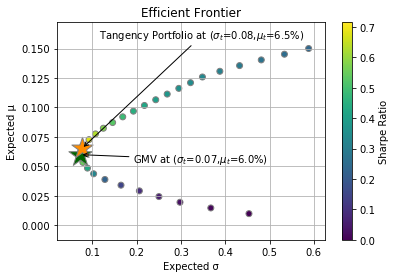

In [5]:
# import optimization package
import scipy.optimize as spo

# def calc_μ_σ_SR()
def calc_μ_σ_SR(w):
    """Calculate μ, σ, and SR for given weights w, returns μ, and cov matrix Σ"""
    global μ, Σ
    w = np.matrix(w).T
    σ_Π = np.sqrt( w.T * Σ * w )
    μ_Π = w.T * μ
    return {'μ':μ_Π, 'σ':σ_Π}

# initially, set equal weights for all assets
num_w = len(portfolio_df)
w = np.matrix( [1 / num_w] * num_w ).T
σ_ary = [] # list to collect volatilities
μ_ary = []
m_ary = np.linspace(.01,.15, 30)

for m in m_ary: # for each target return
    # set contstaints
    constraints = (
        # Lagrangian term for the target return
        {'type':'eq','fun':lambda w: m - r - ((μ - rI).T * np.matrix(w).T).item() },
        # budget eq
        {'type':'eq','fun':lambda w: np.sum(w) - 1}
    )
    # set boundaries, ie weights for each assets can be between -1 and 1
    bounds = tuple((-1, 1) for _ in w) 
    # run minimization
    min_res = spo.minimize(lambda w: calc_μ_σ_SR(w)['σ'], 
                           w, 
                           method='SLSQP',
                           bounds=bounds, 
                           constraints=constraints)
    # collect minimized func results, ie volatilities
    σ_ary.append(min_res['fun'])
    μ_ary.append(calc_μ_σ_SR(min_res['x'])['μ'].item()) # min_res['x'] gives weights
    
    
# do type conversin for plotting
μ_ary = np.array(μ_ary)
σ_ary = np.array(σ_ary)

# plot the efficient frontier
plt.scatter(σ_ary,μ_ary,c=(μ_ary-r)/σ_ary, marker='o', edgecolors='grey')
plt.grid(True)
plt.xlabel('Expected σ')
plt.ylabel('Expected μ')
plt.colorbar(label='Sharpe Ratio')
plt.title("Efficient Frontier");

# show the portfolio with GMV (Globaly Minimal Variance)
w_GMV = (Σ**-1 * I) / (I.T * Σ**-1 * I)
σ_GMV = np.sqrt( w_GMV.T * Σ * w_GMV )
μ_GMV = w_GMV.T * μ
σ_GMV, μ_GMV = σ_GMV.item(), μ_GMV.item()
plt.scatter(σ_GMV, μ_GMV, c='darkgreen', marker='*', s=600, edgecolors='grey');
plt.annotate('GMV at ($σ_t$=%.2f,$μ_t$=%.1f%%)' % (σ_GMV, 100*μ_GMV),
                        xy=(σ_GMV, μ_GMV), xycoords='data',
                        xytext=(120, -5), textcoords='offset points',
                        arrowprops=dict(arrowstyle="->"),
                        horizontalalignment='center', verticalalignment='center');

# show the tangency portfolio
w_t = (Σ**-1 * (μ-rI)) / (I.T * Σ**-1 * (μ-rI))
σ_t = np.sqrt( w_t.T * Σ * w_t )
μ_t = w_t.T * μ
σ_t, μ_t = σ_t.item(), μ_t.item()
plt.scatter(σ_t, μ_t, c='darkorange', marker='*', s=500, edgecolors='grey');
plt.annotate('Tangency Portfolio at ($σ_t$=%.2f,$μ_t$=%.1f%%)' % (σ_t, 100*μ_t),
                        xy=(σ_t, μ_t), xycoords='data',
                        xytext=(120, 120), textcoords='offset points',
                        arrowprops=dict(arrowstyle="->"),
                        horizontalalignment='center', verticalalignment='top');

###### THE END